## Import Lib

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


## Prepare Data

In [2]:
CLASSES = ["background", "flood_area"]

COLORMAP = [
    [0, 0, 0],
    [255, 255, 255]
]

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dir, transform=None):
        super().__init__()
        image_dir = os.path.join(dir, "images")
        self.images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
        self.images.sort()
        
        mask_dir = os.path.join(dir, "masks")
        self.masks = [os.path.join(mask_dir, x) for x in os.listdir(mask_dir)]
        self.masks.sort()
        
        self.transform = transform

    @staticmethod
    def convert_to_segmentation_mask(mask):
        height, width = mask.shape[: 2]
        segmentation_mask = np.zeros((height, width, len(COLORMAP)))
        
        for i, label in enumerate(COLORMAP):
            segmentation_mask[:, :, i] = np.all(mask == label, axis=-1)
        
        return segmentation_mask
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.convert_to_segmentation_mask(mask)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            
            image = transformed["image"]
            mask = transformed["mask"]
            
            return image.float(), mask.argmax(dim=2).long()
        
        else:
            return image.float(), mask.long()

In [4]:
image_size = (256, 256)

train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [5]:
train_dataset = CustomDataset(dir="data/flood_area/train", transform=train_transform)
val_dataset = CustomDataset(dir="data/flood_area/train", transform=val_transform)

In [6]:
class UnNormalize():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor

In [7]:
un_norm = UnNormalize(
    mean=(0.485, 0.456, 0.406), 
    std=(0.229, 0.224, 0.225)
)

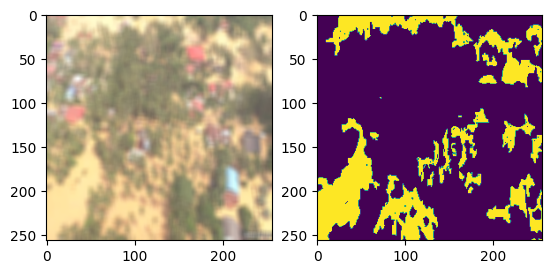

In [8]:
image, mask = train_dataset.__getitem__(0)

plt.subplot(1, 2, 1)
plt.imshow(un_norm(image).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(mask)

plt.show()

## Build Model

In [9]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.block(x)

In [10]:
class Unet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block_down_1 = UnetBlock(3, 64)
        self.block_down_2 = UnetBlock(64, 128)
        self.block_down_3 = UnetBlock(128, 256)
        self.block_down_4 = UnetBlock(256, 512)
        
        self.block_neck = UnetBlock(512, 1024)
        
        self.block_up_1 = UnetBlock(1024 + 512, 512)
        self.block_up_2 = UnetBlock(512 + 256, 256)
        self.block_up_3 = UnetBlock(256 + 128, 128)
        self.block_up_4 = UnetBlock(128 + 64, 64)
        
        self.conv_cls = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x_down_1 = self.block_down_1(x)
        x = F.max_pool2d(x_down_1, kernel_size=2)
        
        x_down_2 = self.block_down_2(x)
        x = F.max_pool2d(x_down_2, kernel_size=2)
        
        x_down_3 = self.block_down_3(x)
        x = F.max_pool2d(x_down_3, kernel_size=2)
        
        x_down_4 = self.block_down_4(x)
        x = F.max_pool2d(x_down_4, kernel_size=2)
        
        x = self.block_neck(x)
        
        x_up_1 = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x_down_4, x_up_1], dim=1)
        x = self.block_up_1(x)
        
        x_up_2 = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x_down_3, x_up_2], dim=1)
        x = self.block_up_2(x)
        
        x_up_3 = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x_down_2, x_up_3], dim=1)
        x = self.block_up_3(x)
        
        x_up_4 = F.interpolate(x, scale_factor=2, mode="bilinear")
        x = torch.cat([x_down_1, x_up_4], dim=1)
        x = self.block_up_4(x)
        
        return self.conv_cls(x)

## Training

In [11]:
batch_size = 16 
num_workers = os.cpu_count()

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
num_classes = 2

model = Unet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

dice = torchmetrics.Dice(num_classes=num_classes, average="macro").to(device)
iou = torchmetrics.JaccardIndex(num_classes=num_classes, task="multiclass", average="macro").to(device)

train_loss = AverageMeter()
train_dice = AverageMeter()
train_iou = AverageMeter()

val_loss = AverageMeter()
val_dice = AverageMeter()
val_iou = AverageMeter()

In [15]:
n_epochs = 3

for epoch in range(n_epochs):
    # Training step
    train_loss.reset()
    train_dice.reset()
    train_iou.reset()
    
    model.train()
    
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        
        logits = model(X)
        
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n = X.shape[0]
        train_loss.update(loss.item(), n)
        masks = logits.argmax(dim=1).squeeze(dim=1) # B, C, H, W -> B, 1, H, W -> B, H, W
        train_dice.update(dice(masks, y).item(), n)
        train_iou.update(iou(masks, y).item(), n)
    
    
    # valation step
    val_loss.reset()
    val_dice.reset()
    val_iou.reset()    
        
    model.eval()
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader):
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            
            loss = criterion(logits, y)
            
            n = X.shape[0]
            val_loss.update(loss.item(), n)
            masks = logits.argmax(dim=1).squeeze(dim=1) # B, C, H, W -> B, 1, H, W -> B, H, W
            val_dice.update(dice(masks, y).item(), n)
            val_iou.update(iou(masks, y).item(), n)
            
    print(f"Epoch: {epoch+1}", end="")
    print(f"- loss: {train_loss.avg:.4f} - dice: {train_dice.avg:.4f} - iou: {train_iou.avg:.4f}", end="")
    print(f"- val_loss: {val_loss.avg:.4f} - val_dice: {val_dice.avg:.4f} - val_iou: {val_iou.avg:.4f}")

Epoch: 1- loss: 0.5908 - dice: 0.6754 - iou: 0.5240- val_loss: 0.5313 - val_dice: 0.6980 - val_iou: 0.5536
Epoch: 2- loss: 0.5464 - dice: 0.7252 - iou: 0.5788- val_loss: 0.4640 - val_dice: 0.7838 - val_iou: 0.6488
Epoch: 3- loss: 0.5106 - dice: 0.7264 - iou: 0.5790- val_loss: 0.4617 - val_dice: 0.7403 - val_iou: 0.6016


## Predict

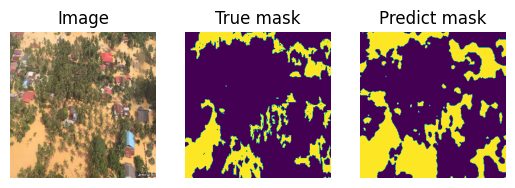

In [19]:
image, mask = val_dataset.__getitem__(0)

with torch.inference_mode():
    predict_mask = model(image.unsqueeze(0).to(device))[0]
    predict_mask = predict_mask.argmax(dim=0).squeeze().cpu()

plt.subplot(1, 3, 1)
plt.imshow(un_norm(image).permute(1, 2, 0))
plt.axis(False)
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.axis(False)
plt.title("True mask")

plt.subplot(1, 3, 3)
plt.imshow(predict_mask)
plt.axis(False)
plt.title("Predict mask")

plt.show()



In [3]:
import yaml

with open('data/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.loader.SafeLoader)

In [4]:
config

{'path': 'data/flood_area',
 'train': 'train',
 'val': 'val',
 'test': None,
 'names': {0: 'background', 1: 'flood_area'},
 'color': {0: [0, 0, 0], 1: [255, 255, 255]}}